In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import shap
import umap

from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from skfda import FDataGrid
from skfda.representation.basis import BSplineBasis, FourierBasis
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.ml.clustering import KMeans as FdaKMeans

from scipy.stats import linregress
from scipy.interpolate import interp1d

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.cluster import KMeans as SKKMeans

# 1. Loading and Exploring Data


Training Data Sample:
   SUBJID    AGE  SEX   BIO     T      Y  CLUSTER
0       0  74.97    0  2.07  0.00  48.00      NaN
1       0  74.97    0  2.07  0.79  40.02      NaN
2       0  74.97    0  2.07  1.44  30.08      NaN
3       0  74.97    0  2.07  2.18  19.86      NaN
4       0  74.97    0  2.07  2.82  12.78      NaN

Test Data Sample:
   SUBJID    AGE  SEX   BIO     Y0  CLUSTER
0      10  65.37    1  2.72  38.81      NaN
1      23  55.75    1  2.35  47.02      NaN
2      25  71.11    0  2.46  46.97      NaN
3      30  63.98    1  1.81  46.63      NaN
4      39  71.97    0  1.98  48.00      NaN

Missing Values in Training Data:
SUBJID        0
AGE           0
SEX           0
BIO           0
T             0
Y             0
CLUSTER    5835
dtype: int64

Missing Values in Test Data:
SUBJID       0
AGE          0
SEX          0
BIO          0
Y0           0
CLUSTER    200
dtype: int64

Training Data Statistics:
            SUBJID          AGE          SEX          BIO            T  \
co

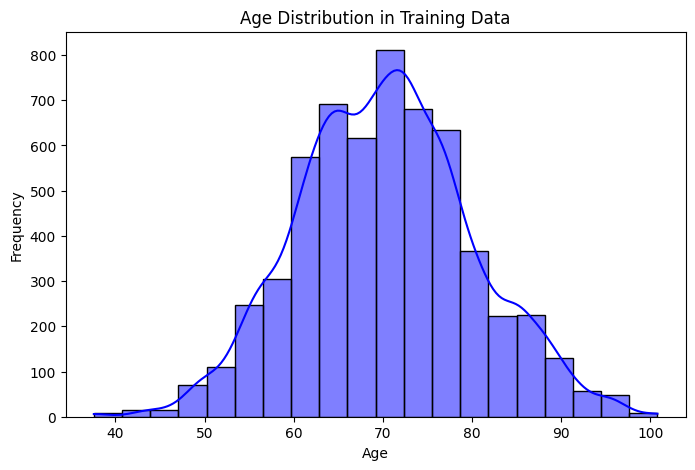

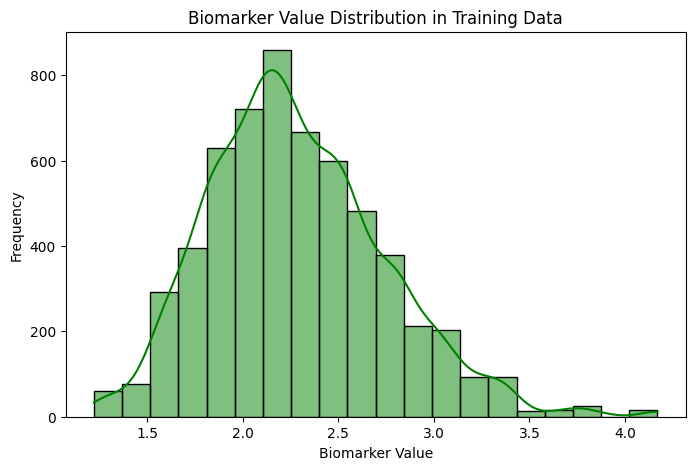

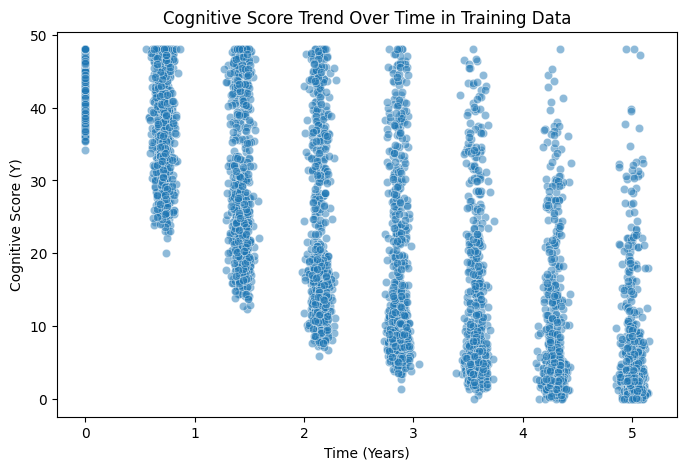

C:\Users\mowlai\AppData\Local\Temp\ipykernel_34196\3548576460.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_df["SEX"], palette="coolwarm")


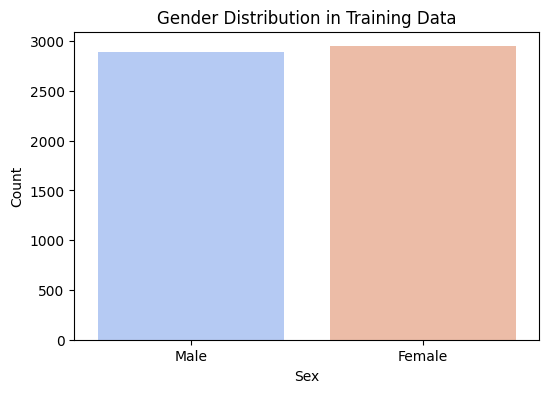

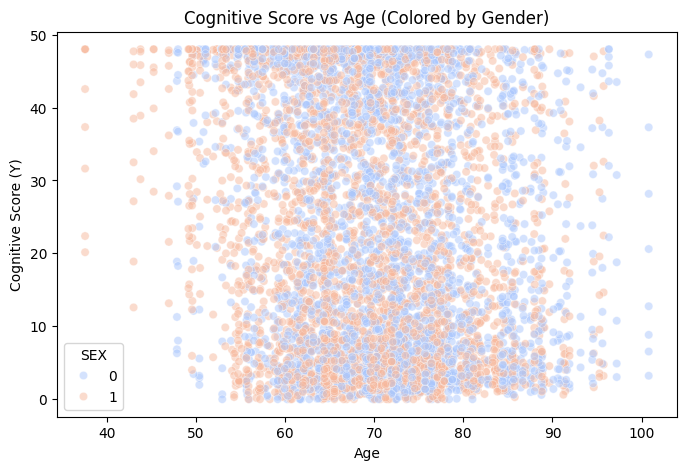

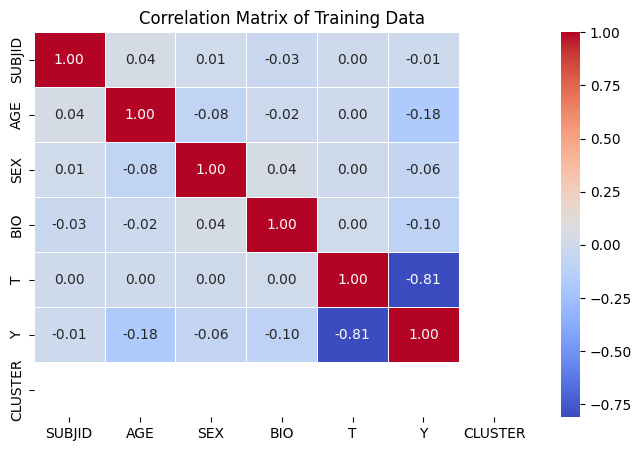

In [ ]:
# training data
train_path = "train.csv" # Change accordingly
train_df = pd.read_csv(train_path)

# test data
test_path = "test.csv" # Change accordingly
test_df = pd.read_csv(test_path)

# Display first few rows of both datasets
print("Training Data Sample:")
print(train_df.head())

print("\nTest Data Sample:")
print(test_df.head())

# Check for missing values
print("\nMissing Values in Training Data:")
print(train_df.isnull().sum())

print("\nMissing Values in Test Data:")
print(test_df.isnull().sum())

# Basic Statistics
print("\nTraining Data Statistics:")
print(train_df.describe())

print("\nTest Data Statistics:")
print(test_df.describe())

# Data Types
print("\nTraining Data Types:")
print(train_df.dtypes)

print("\nTest Data Types:")
print(test_df.dtypes)

# Unique Subject Count
print("\nNumber of Unique Subjects in Training Data:", train_df["SUBJID"].nunique())
print("Number of Unique Subjects in Test Data:", test_df["SUBJID"].nunique())

# Distribution of Age
plt.figure(figsize=(8,5))
sns.histplot(train_df["AGE"], bins=20, kde=True, color="blue")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution in Training Data")
plt.show()

# Distribution of Biomarker Values
plt.figure(figsize=(8,5))
sns.histplot(train_df["BIO"], bins=20, kde=True, color="green")
plt.xlabel("Biomarker Value")
plt.ylabel("Frequency")
plt.title("Biomarker Value Distribution in Training Data")
plt.show()

# Distribution of Cognitive Scores Over Time
plt.figure(figsize=(8,5))
sns.scatterplot(data=train_df, x="T", y="Y", alpha=0.5)
plt.xlabel("Time (Years)")
plt.ylabel("Cognitive Score (Y)")
plt.title("Cognitive Score Trend Over Time in Training Data")
plt.show()

# Gender Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=train_df["SEX"], palette="coolwarm")
plt.xticks(ticks=[0, 1], labels=["Male", "Female"])
plt.xlabel("Sex")
plt.ylabel("Count")
plt.title("Gender Distribution in Training Data")
plt.show()

# Relationship Between Age and Cognitive Score
plt.figure(figsize=(8,5))
sns.scatterplot(data=train_df, x="AGE", y="Y", alpha=0.5, hue=train_df["SEX"], palette="coolwarm")
plt.xlabel("Age")
plt.ylabel("Cognitive Score (Y)")
plt.title("Cognitive Score vs Age (Colored by Gender)")
plt.show()

# Correlation Matrix
plt.figure(figsize=(8,5))
sns.heatmap(train_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Training Data")
plt.show()

# 2. FDA-based Approach

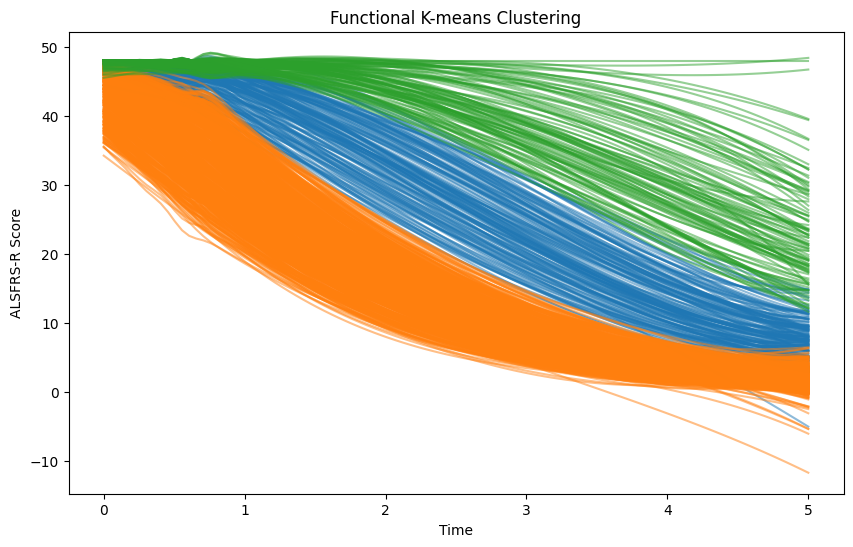

In [ ]:
# Functional Data Clustering
# Group the data by SUBJID to create longitudinal trajectories
subject_data = {subj: sub_df for subj, sub_df in train_df.groupby("SUBJID")}

# Create a common set of time points for interpolation
common_time_points = np.linspace(0, 5, 100)  # 100 time points between 0 and 5 years

# Interpolate the ALSFRS-R scores for each subject to the common time points
alsfrs_scores = []
for subj, sub_df in subject_data.items():
    interp_func = interp1d(sub_df['T'], sub_df['Y'], kind='linear', fill_value="extrapolate")
    interpolated_scores = interp_func(common_time_points)
    alsfrs_scores.append(interpolated_scores)

# Create FDataGrid object for functional data
fd = FDataGrid(data_matrix=alsfrs_scores, grid_points=common_time_points)

# Smooth the data using B-spline basis functions
basis = BSplineBasis(n_basis=10)  # 10 basis functions
smoother = BasisSmoother(basis)
smoothed_fd = smoother.fit_transform(fd)

# Reshape the data_matrix to remove the extra dimension
smoothed_data = smoothed_fd.data_matrix.squeeze()  # Shape: (n_patients, n_time_points)

# Apply functional K-means clustering
n_clusters = 3  # Assume 3 clusters
kmeans = FdaKMeans(n_clusters=n_clusters)
kmeans.fit(smoothed_fd)
labels = kmeans.predict(smoothed_fd)

# Add cluster labels to the original data
for i, subj in enumerate(subject_data.keys()):
    train_df.loc[train_df['SUBJID'] == subj, 'CLUSTER'] = labels[i]

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    cluster_data = smoothed_data[labels == cluster]  # Get data for the current cluster
    plt.plot(common_time_points, cluster_data.T, color=f'C{cluster}', alpha=0.5)  # Plot each patient in the cluster
plt.title('Functional K-means Clustering')
plt.xlabel('Time')
plt.ylabel('ALSFRS-R Score')
plt.show()

In [ ]:
# Classification
# Prepare the data for classification
baseline_data = train_df.groupby('SUBJID').first().reset_index()  # Get the first row for each subject

# Encode categorical variables (e.g., Sex) into numerical values
label_encoder = LabelEncoder()
baseline_data['SEX'] = label_encoder.fit_transform(baseline_data['SEX'])  # Encode 'Male' and 'Female' into 0 and 1

# Feature Engineering: Create new features
baseline_data['AGE_BIO_RATIO'] = baseline_data['AGE'] / baseline_data['BIO']  # Example of a new feature

# Select features for classification
X = baseline_data[['AGE', 'SEX', 'BIO', 'Y', 'AGE_BIO_RATIO']]  # Baseline covariates (Y is the baseline ALSFRS-R score)
y = baseline_data['CLUSTER']  # Cluster labels

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

clf = xgb.XGBClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_clf = grid_search.best_estimator_
print("Best Parameters:", best_params)

# Evaluate the classifier using cross-validation
cv_scores = cross_val_score(best_clf, X_scaled, y, cv=StratifiedKFold(n_splits=5))
print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

# Predict on the test set
y_pred = best_clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Set Accuracy: {accuracy:.2f}')
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Cross-Validation Accuracy: 0.73 ± 0.02
Test Set Accuracy: 0.69
Classification Report:
               precision    recall  f1-score   support

         0.0       0.26      0.31      0.29        29
         1.0       0.87      0.86      0.87       110
         2.0       0.35      0.29      0.32        21

    accuracy                           0.69       160
   macro avg       0.50      0.49      0.49       160
weighted avg       0.69      0.69      0.69       160



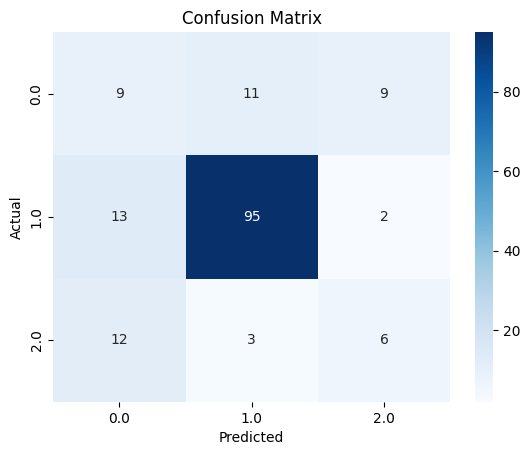

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

(640, 5, 3)
(640, 5)


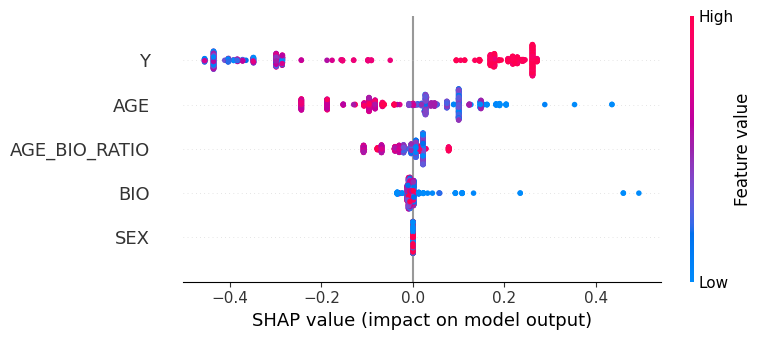

In [ ]:
# Feature Importance using SHAP
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X_train)
print(shap_values.shape)
print(X_train.shape)

# Summary plot
shap.summary_plot(shap_values[..., 0], X_train, feature_names=['AGE', 'SEX', 'BIO', 'Y', 'AGE_BIO_RATIO'])

In [ ]:
subject_ids = train_data["SUBJID"].unique()
subject_cluster_map = dict(zip(subject_ids, labels))
train_data["CLUSTER"] = train_data["SUBJID"].map(subject_cluster_map)
train_data.to_csv('train_with_clusters.csv', index=False)
# train_data.head()

In [ ]:
# Now, apply the classifier to the test.csv file
test_data = pd.read_csv('test.csv') # Change accordingly

# Ensure the test data has the same columns as the training data
test_data.rename(columns={'Y0': 'Y'}, inplace=True)

# Encode 'SEX' in the test data
test_data['SEX'] = label_encoder.transform(test_data['SEX'])

# Feature Engineering: Create new features for the test data
test_data['AGE_BIO_RATIO'] = test_data['AGE'] / test_data['BIO']

# Select features for prediction
X_test_data = test_data[['AGE', 'SEX', 'BIO', 'Y', 'AGE_BIO_RATIO']]

# Standardize the test data
X_test_data_scaled = scaler.transform(X_test_data)

# Predict cluster labels for the test data
test_data['Predicted_Cluster'] = best_clf.predict(X_test_data_scaled)

# Save the results
test_data.to_csv('test_with_clusters.csv', index=False)

# Display the test data with predicted clusters
print("Test Data with Predicted Clusters:\n", test_data[['SUBJID', 'Predicted_Cluster']])

Test Data with Predicted Clusters:
      SUBJID  Predicted_Cluster
0        10                  1
1        23                  0
2        25                  1
3        30                  1
4        39                  1
..      ...                ...
195     985                  0
196     986                  1
197     989                  1
198     995                  1
199     998                  2

[200 rows x 2 columns]


In [ ]:
test_data['CLUSTER'] = test_data['Predicted_Cluster']
test_data.drop(columns=['AGE_BIO_RATIO', 'Predicted_Cluster'], inplace= True)
test_data.to_csv('test_cluster_fda.csv', index=False)
test_data.head()

,SUBJID,AGE,SEX,BIO,Y,CLUSTER
0,10,65.37,1,2.72,38.81,1
1,23,55.75,1,2.35,47.02,0
2,25,71.11,0,2.46,46.97,1
3,30,63.98,1,1.81,46.63,1
4,39,71.97,0,1.98,48.00,1


Since the FDA approach did not perform well across all the classes, we explored informed feature extraction aiming to achieve better classification performance, in Section 3.

# 3. Feature-extraction Approach

$\Delta Y / \Delta T$ information is extracted to capture the rate of progression.

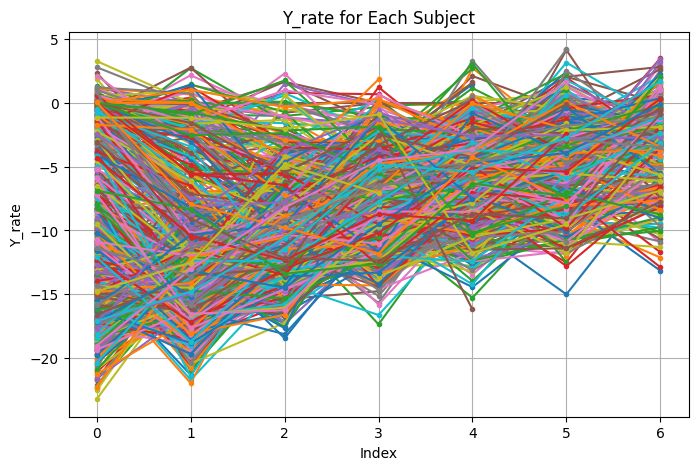

In [ ]:
# Initialize the plot
plt.figure(figsize=(8, 5))

# Loop through each SUBJID and plot Y_rate
Y_rate_collection = []
Y_collection = []
Y_rate_lengths = []
df = train_df
for subj, sub_df in df.groupby("SUBJID"):
    Y_rate = (np.array(sub_df["Y"][1:]) - np.array(sub_df["Y"][:-1]))/(np.array(sub_df["T"][1:]) - np.array(sub_df["T"][:-1]))
    Y_collection.append(np.array(sub_df["Y"]))
    Y_rate_collection.append(Y_rate)
    Y_rate_lengths.append(Y_rate.shape[0])
    plt.plot(Y_rate, marker='.', linestyle='-', label=f"Subject {subj}") #, color = '#1f77b4')
    # if subj > 10: break

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Y_rate")
plt.title("Y_rate for Each Subject")
# plt.legend(title="SUBJID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show the plot
plt.show()

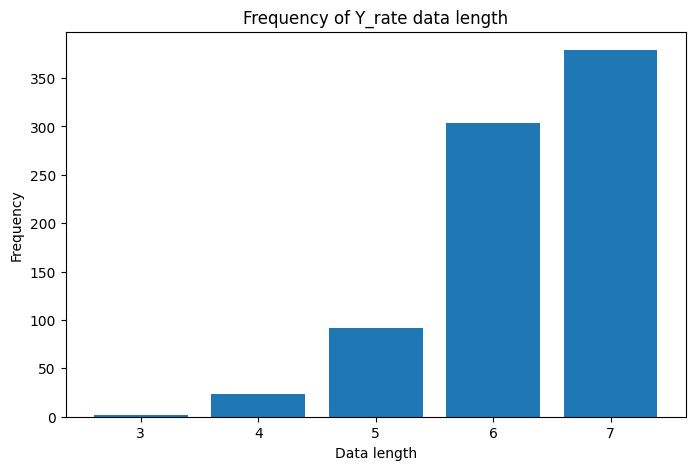

In [ ]:
from collections import Counter

# Count the frequency of each data_length
cluster_counts = Counter(np.array(Y_rate_lengths))

# Prepare data for plotting
Y_rate_data_length = list(cluster_counts.keys())
frequencies = list(cluster_counts.values())

# Plot the frequencies of Y_rate data lengths
plt.figure(figsize=(8, 5))
plt.bar(Y_rate_data_length, frequencies)
plt.title('Frequency of Y_rate data length')
plt.xlabel('Data length')
plt.ylabel('Frequency')
plt.xticks(Y_rate_data_length)
plt.show()

In [ ]:
# bla = Y_collection[idx]
# np.max(Y_collection[idx]) - np.min(Y_collection[idx])
# Y_collection[idx][-1]

## Extracted featuers

In [ ]:
# # Highest 3 absolute Y_rate values
# Y_rate_featuers = []
# for idx, val in enumerate(Y_rate_collection):
#     sorted_abs_values = np.sort(abs(val))
#     Y_rate_featuers.append(sorted_abs_values[-3:])
#     # Y_rate_featuers.append(list(sorted_abs_values[-3:]) + [Y_collection[idx][0], Y_collection[idx][-1]])
#     # if idx > 5: break
# Y_rate_featuers = np.array(Y_rate_featuers)
# Y_rate_featuers

# # [Mean, Median, Max] absolute Y_rate values
Y_rate_featuers = []
for idx, val in enumerate(Y_rate_collection):
    sorted_abs_values = np.sort(abs(val))
    Y_rate_featuers.append(np.round([np.mean(sorted_abs_values), np.median(sorted_abs_values),
                                      np.max(sorted_abs_values),Y_collection[idx][0],
                                    #   Y_collection[idx][-1]],4))
                                      np.max(Y_collection[idx]) - np.min(Y_collection[idx])],4))

    # if idx > 5: break
Y_rate_featuers = np.array(Y_rate_featuers)
Y_rate_featuers

array([[10.2156, 10.5819, 15.2923, 48.    , 44.56  ],
       [ 5.8574,  6.9552, 12.3288, 37.3   , 34.91  ],
       [ 7.163 ,  6.0986, 16.4236, 42.67  , 42.67  ],
       ...,
       [ 7.405 ,  6.6081, 13.5811, 38.54  , 37.42  ],
       [ 9.7994,  9.802 , 14.7801, 44.04  , 39.12  ],
       [ 8.1673,  5.3944, 17.0959, 40.45  , 39.1   ]])

In [ ]:
Y_rate_featuers

array([[10.2156, 10.5819, 15.2923, 48.    , 44.56  ],
       [ 5.8574,  6.9552, 12.3288, 37.3   , 34.91  ],
       [ 7.163 ,  6.0986, 16.4236, 42.67  , 42.67  ],
       ...,
       [ 7.405 ,  6.6081, 13.5811, 38.54  , 37.42  ],
       [ 9.7994,  9.802 , 14.7801, 44.04  , 39.12  ],
       [ 8.1673,  5.3944, 17.0959, 40.45  , 39.1   ]])

## k-means clustering

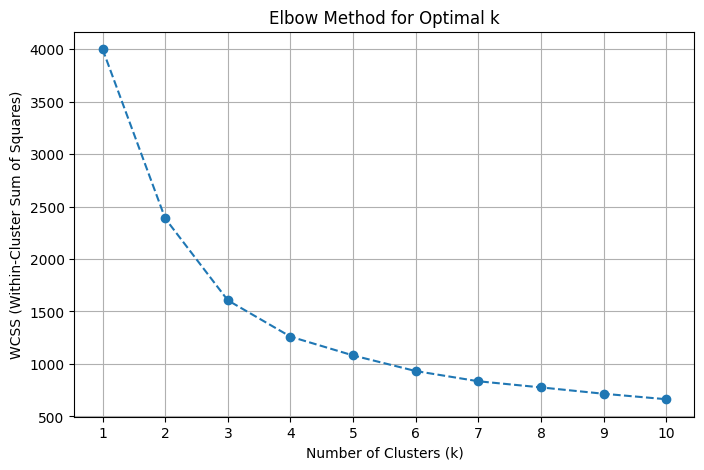

In [ ]:
X = Y_rate_featuers

# ---------------------------
# Data Scaling
# ---------------------------
scaler = StandardScaler()
X = scaler.fit_transform(X)

# List to store WCSS values
wcss = []

# Try different values of k (from 1 to 10)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.xticks(range(1, 11))
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

def silhouette_plot(X, clusters, num_clusters):
    # Compute silhouette scores
    silhouette_vals = silhouette_samples(X, clusters)
    avg_silhouette_score = silhouette_score(X, clusters)

    # Sort silhouette values by cluster
    y_lower = 10
    colors = ['r','g','b']

    fig, ax = plt.subplots(figsize=(8, 5))
    for i in range(num_clusters):
        cluster_silhouette_vals = silhouette_vals[clusters == i]
        cluster_silhouette_vals.sort()
        y_upper = y_lower + len(cluster_silhouette_vals)

        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7, color=colors[i])
        ax.text(-0.02, (y_lower + y_upper) / 2, str(i), fontsize=12)
        y_lower = y_upper + 10

    # Plot formatting
    # ax.axvline(avg_silhouette_score, color="red", linestyle="--")  # Average silhouette score
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster")
    ax.set_title("Silhouette Plot for Clustering")
    plt.show()

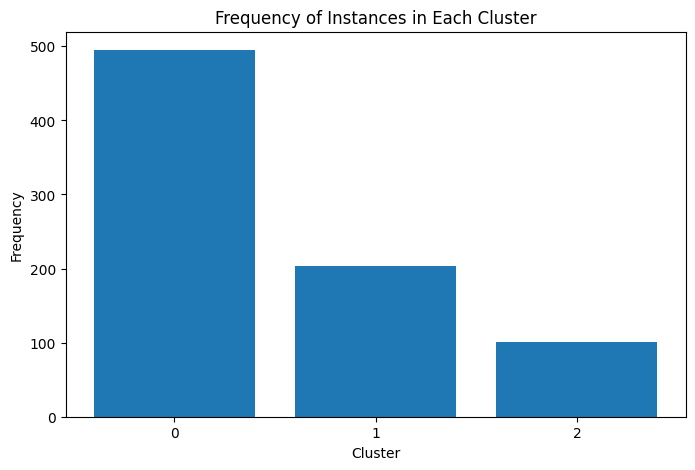

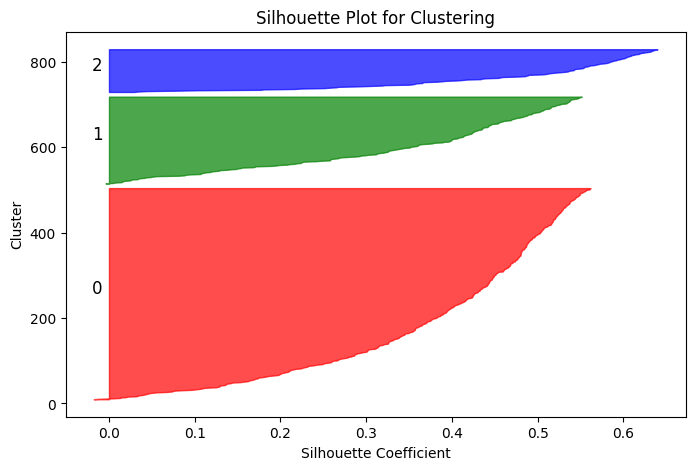

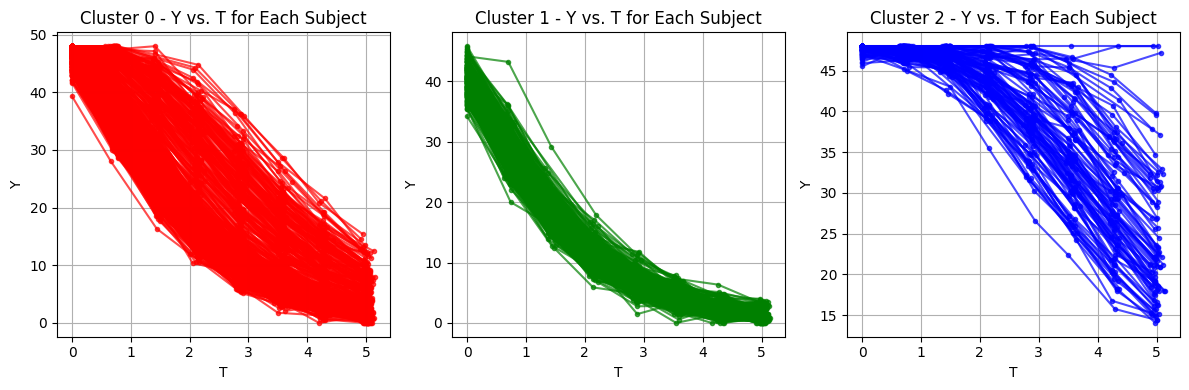

In [ ]:
X = Y_rate_featuers

# ---------------------------
# Data Scaling
# ---------------------------
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ---------------------------
# Unsupervised Clustering
# ---------------------------
n_clusters = 3  # Number of clusters/subtypes

# K-means clustering (Pedregosa et al., 2011)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# ---------------------------
# bar plot
# ---------------------------
from collections import Counter

# Count the frequency of each cluster
cluster_counts = Counter(kmeans_labels)

# Prepare data for plotting
clusters = list(cluster_counts.keys())
frequencies = list(cluster_counts.values())

# Plot the frequencies of cluster instances
plt.figure(figsize=(8, 5))
plt.bar(clusters, frequencies)
plt.title('Frequency of Instances in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.xticks(clusters)  # Ensures each cluster is labeled properly
plt.show()

# ---------------------------
# silhouette plot
# ---------------------------
silhouette_plot(X, kmeans_labels, n_clusters)


# ---------------------------
# Cluster subplots
# ---------------------------
colors = ['r','g','b']

# Number of clusters (adjust based on your data)
n_clusters = len(np.unique(kmeans_labels))

# Calculate number of rows (round up to ensure all clusters are displayed)
n_rows = (n_clusters + 1) // 3  # Two columns, so rows are half the number of clusters

# Create subplots (n_rows rows and 3 columns)
fig, axes = plt.subplots(n_rows, 3, figsize=(12, 4 * n_rows))

# Flatten the axes array for easy indexing (in case n_rows x 2 is a 2D array)
axes = axes.flatten()


# Loop through each cluster and plot Y vs. T on respective subplot
for cluster_idx in np.sort(np.unique(kmeans_labels)):
    counter = 0
    ax = axes[cluster_idx]  # Select the appropriate subplot for the cluster
    for subj, sub_df in df.groupby("SUBJID"):
        if kmeans_labels[counter] == cluster_idx:
            ax.plot(sub_df["T"], sub_df["Y"], marker='.', linestyle='-', label=f"Subject {subj}",
                    color=colors[kmeans_labels[counter]], alpha=0.7)
        counter += 1

    # Customize each subplot
    ax.set_xlabel("T")
    ax.set_ylabel("Y")
    ax.set_title(f"Cluster {cluster_idx} - Y vs. T for Each Subject")
    ax.grid(True)
    # ax.legend(title="SUBJID", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlap and ensure a clean display
plt.tight_layout()

# Show the plot
plt.show()

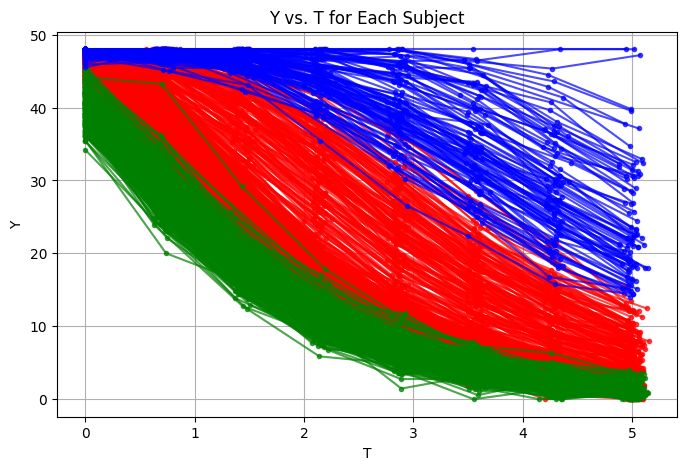

In [ ]:
import time
# Initialize the plot
# colors = ['r','g','b'] # Highest 3 absolute Y_rate values

plt.figure(figsize=(8, 5))

# Loop through each SUBJID and plot Y vs. T
for cluster_idx in np.sort(clusters):
    counter = 0
    for subj, sub_df in df.groupby("SUBJID"):
        if kmeans_labels[counter] == cluster_idx:
            plt.plot(sub_df["T"], sub_df["Y"], marker='.', linestyle='-', label=f"Subject {subj}", \
                    color = colors[kmeans_labels[counter]], alpha = 0.7)
        counter += 1
        # if subj > 10: break
    # time.sleep(2)

# Customize the plot
plt.xlabel("T")
plt.ylabel("Y")
plt.title("Y vs. T for Each Subject")
# plt.legend(title="SUBJID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show the plot
plt.show()

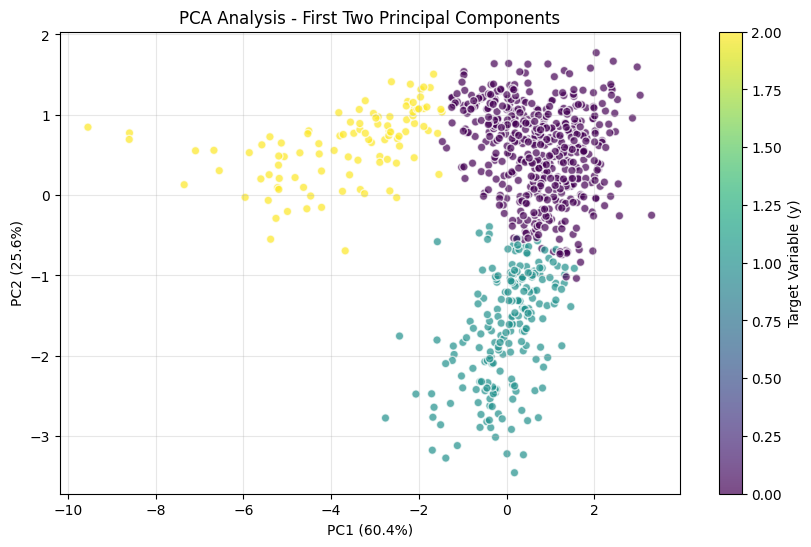

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features first (important for PCA)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_std)

# Create a DataFrame with the principal components
pca_result = pd.DataFrame(data=principal_components,
                          columns=['PC1', 'PC2'])

# Plot the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result['PC1'],
                     pca_result['PC2'],
                     c=kmeans_labels,
                     cmap='viridis',
                     alpha=0.7,
                     edgecolors='w')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('PCA Analysis - First Two Principal Components')
plt.colorbar(scatter, label='Target Variable (y)')
plt.grid(True, alpha=0.3)
plt.show()

## Training with Cluster labels

In [ ]:
classification_feature = []
for subj, sub_df in df.groupby("SUBJID"):

    # Get the first row of THIS subject's data
    first_row = sub_df.iloc[0].to_numpy()
    classification_feature.append(first_row[[1,2,3,5]])
classification_feature = np.array(classification_feature)

c:\Users\mowlai\.conda\envs\water\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mowlai\.conda\envs\water\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Logistic Regression (Weighted) - Average CV F1-score: 0.7246
Random Forest (Weighted) - Average CV F1-score: 0.7728
Decision Tree (Weighted) - Average CV F1-score: 0.7674
SVC (Weighted) - Average CV F1-score: 0.7441


c:\Users\mowlai\.conda\envs\water\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:31:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\mowlai\.conda\envs\water\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:31:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\mowlai\.conda\envs\water\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:31:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\mowlai\.co

XGBoost (Scale_pos_weight) - Average CV F1-score: 0.7778

Best Model Selected (Based on F1-score): XGBoost (Scale_pos_weight)


c:\Users\mowlai\.conda\envs\water\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:31:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)



Final Model - XGBoost (Scale_pos_weight) F1-score: 0.79
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        99
           1       0.88      0.88      0.88        41
           2       0.42      0.25      0.31        20

    accuracy                           0.80       160
   macro avg       0.70      0.67      0.68       160
weighted avg       0.78      0.80      0.79       160



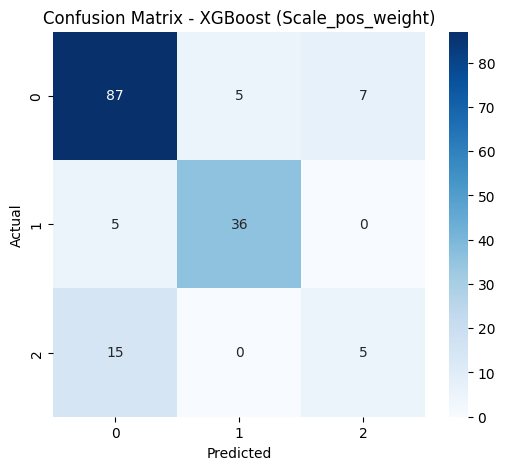

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score

# 1. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Compute scale_pos_weight for XGBoost
scale_pos_weight = pd.Series(y_train).value_counts()[0] / pd.Series(y_train).value_counts()[1]

# 3. Initialize cost-sensitive models
models = {
    "Logistic Regression (Weighted)": LogisticRegression(class_weight='balanced', random_state=42),
    "Random Forest (Weighted)": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "Decision Tree (Weighted)": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "SVC (Weighted)": SVC(class_weight='balanced', probability=True, random_state=42),
    "XGBoost (Scale_pos_weight)": xgb.XGBClassifier(objective='binary:logistic',
                                                    n_estimators=100, learning_rate=0.1, max_depth=3,
                                                    subsample=0.8, scale_pos_weight=scale_pos_weight,
                                                    random_state=42)
}

# 4. Perform 5-fold cross-validation using F1-score
cv_scores = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(f1_score, average='weighted'))
    cv_scores[name] = scores.mean()
    print(f"{name} - Average CV F1-score: {scores.mean():.4f}")

# Select the best model based on F1-score
best_model_name = max(cv_scores, key=cv_scores.get)
best_model = models[best_model_name]

print(f"\nBest Model Selected (Based on F1-score): {best_model_name}")

# 5. Train the best model on the full training set
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# 6. Evaluate the best model
print(f"\nFinal Model - {best_model_name} F1-score: {f1_score(y_test, y_pred, average='weighted'):.2f}")
print(classification_report(y_test, y_pred))

# 7. Confusion Matrix
plt.figure(figsize=(6, 5))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# training on the full data
best_model = best_model.fit(classification_feature,kmeans_labels)

c:\Users\mowlai\.conda\envs\water\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:31:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


## Classification of Test data

In [ ]:
# Read and view the test data
df_test = pd.read_csv('test.csv') # Change accordingly
test_classification_feature = df_test[['AGE','SEX','BIO','Y0']].to_numpy()

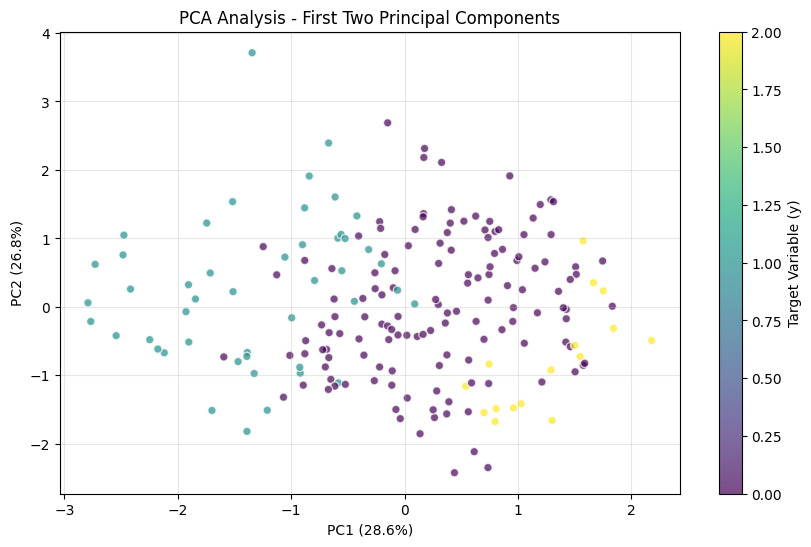

In [ ]:
y_test_final = best_model.predict(test_classification_feature)

X = test_classification_feature


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features first (important for PCA)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_std)

# Create a DataFrame with the principal components
pca_result = pd.DataFrame(data=principal_components,
                          columns=['PC1', 'PC2'])

# Plot the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result['PC1'],
                     pca_result['PC2'],
                     c=y_test_final,
                     cmap='viridis',
                     alpha=0.7,
                     edgecolors='w')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('PCA Analysis - First Two Principal Components')
plt.colorbar(scatter, label='Target Variable (y)')
plt.grid(True, alpha=0.3)
plt.show()

Saving the files

In [ ]:
subject_ids = df["SUBJID"].unique()
subject_cluster_map = dict(zip(subject_ids, kmeans_labels))

df["CLUSTER"] = df["SUBJID"].map(subject_cluster_map)

In [ ]:
df.to_csv('train_cluster.csv', index=False)
df.head()

,SUBJID,AGE,SEX,BIO,T,Y,CLUSTER
0,0,74.97,0,2.07,0.00,48.00,0
1,0,74.97,0,2.07,0.79,40.02,0
2,0,74.97,0,2.07,1.44,30.08,0
3,0,74.97,0,2.07,2.18,19.86,0
4,0,74.97,0,2.07,2.82,12.78,0


In [ ]:
df_test['CLUSTER'] = y_test_final
df_test.to_csv('test_cluster.csv', index=False)
df_test.head()

,SUBJID,AGE,SEX,BIO,Y0,CLUSTER
0,10,65.37,1,2.72,38.81,1
1,23,55.75,1,2.35,47.02,0
2,25,71.11,0,2.46,46.97,0
3,30,63.98,1,1.81,46.63,0
4,39,71.97,0,1.98,48.00,0


Additional feature extraction is explored in Section 4 to check whether using the information from the full Y-data would help achieving better classification performance.

# 4. Exploring Advanced Features for Clustering

Goal: Convert time-series data into meaningful numerical features.

✅ Combines Both Feature-Based and Functional Clustering

✅ Uses FDA Smoothing for Time-Series Data Representation

✅ Uses KMeans on Both Extracted Features & Smoothed Functional Data

✅ Finds the Optimal Number of Clusters using WCSS & Silhouette Scores

✅ Merges Both Clustering Results into the Final Dataset

✅ Feature Engineering from Trajectories:

    Y_slope: Rate of cognitive decline over time (linear regression slope).

    Y_intercept: Initial cognitive score projection.

    Y_range: Difference between max & min cognitive scores.

    Y_skew: Measure of skewness in cognitive score distribution.

    Y_mean, Y_median, Y_min, Y_max: Summary statistics of Y.

In [ ]:
# Step 1: Extract Features from Time-Series Data (Feature-Based Clustering)
feature_list = []
subject_ids = train_df["SUBJID"].unique()

for sid in subject_ids:
    subject_data = train_df[train_df["SUBJID"] == sid]
    times = subject_data["T"].values
    scores = subject_data["Y"].values

    if len(times) > 1:
        slope, intercept = np.polyfit(times, scores, 1)
    else:
        slope, intercept = 0, scores[0]

    subject_features = {
        "SUBJID": sid,
        "Y_slope": slope,
        "Y_intercept": intercept,
        "Y_range": scores.max() - scores.min(),
        "Y_skew": pd.Series(scores).skew(),
        "Y_mean": scores.mean(),
        "Y_median": np.median(scores),
        "Y_min": scores.min(),
        "Y_max": scores.max(),
        "AGE": subject_data["AGE"].values[0],
        "SEX": subject_data["SEX"].values[0],
        "BIO": subject_data["BIO"].values[0],
    }
    feature_list.append(subject_features)

train_features = pd.DataFrame(feature_list)

# Normalize extracted features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_features.drop(columns=["SUBJID"]))

# Perform Feature-Based KMeans Clustering
kmeans_features = SKKMeans(n_clusters=3, random_state=42)
feature_clusters = kmeans_features.fit_predict(X_scaled)

# Assign feature-based clusters to subjects
train_features["Feature_Cluster"] = feature_clusters
train_features


,SUBJID,Y_slope,Y_intercept,Y_range,Y_skew,Y_mean,Y_median,Y_min,Y_max,AGE,SEX,BIO,Feature_Cluster
0,0,-9.735670,44.748705,44.56,0.361263,22.760000,19.860,3.44,48.00,74.97,0,2.07,0
1,1,-7.576068,34.045746,34.91,1.054802,13.388333,4.920,2.39,37.30,68.62,1,2.31,2
2,2,-8.039257,35.450281,42.67,1.599338,13.158571,9.460,0.00,42.67,76.48,0,1.70,2
3,3,-6.472387,28.635575,35.05,1.868322,10.688571,5.330,1.15,36.20,85.23,1,1.83,2
4,4,-7.837285,34.047750,40.72,1.805774,12.540000,6.450,1.78,42.50,67.66,0,2.83,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,993,-8.936088,49.572930,40.18,0.095987,27.087500,26.255,7.82,48.00,63.18,0,1.85,0
796,994,-8.787233,39.114495,44.60,1.210875,15.464286,7.260,1.45,46.05,59.98,0,2.66,2
797,996,-7.394044,33.921550,37.42,0.826409,15.362500,11.335,1.12,38.54,87.98,0,1.54,2
798,997,-10.727317,40.931909,39.12,1.322610,19.134000,13.560,4.92,44.04,76.41,1,1.85,0


In [ ]:
# Define features and target variable
X = train_features.drop(columns=["SUBJID", "Feature_Cluster"])
y = train_features["Feature_Cluster"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.9625
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        84
           1       1.00      1.00      1.00        22
           2       0.93      0.96      0.95        54

    accuracy                           0.96       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.96      0.96      0.96       160



Now since the test data is having a different features(missing the times) we approach the FDA and others